In [1]:
import os
from multiprocessing import Pool

import mmcv
import numpy as np
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from pyquaternion import Quaternion
import copy

# https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L834
def map_pointcloud_to_image(
    pc,
    im,

    cam_intrinsic,
    min_dist: float = 0.0,
):

    # Points live in the point sensor frame. So they need to be
    # transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle
    # frame for the timestamp of the sweep.

    pc = LidarPointCloud(pc.T)
    # pc.rotate(Quaternion(lidar2ego_rotation).rotation_matrix)
    # pc.translate(np.array(lidar2ego_translation))

    # Second step: transform from ego to the global frame.
    # pc.rotate(Quaternion(ego2global_rotation).rotation_matrix)
    # pc.translate(np.array(ego2global_translation))

    # Third step: transform from global into the ego vehicle
    # frame for the timestamp of the image.
    # pc.translate(-np.array(cam_ego2global_translation))
    # pc.rotate(Quaternion(cam_ego2global_rotation).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    t_camera_lidar= np.array([[-0.0079802 , -0.99985409,  0.0151049 ,  0.15099999],
       [ 0.118497  , -0.0159445 , -0.9928264 , -0.461     ],
       [ 0.99292243, -0.0061331 ,  0.1186069 , -0.91500002],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

    pc.transform(t_camera_lidar)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    coloring = depths

    # Take the actual picture (matrix multiplication with camera-matrix
    # + renormalization).
    points = view_points(pc.points[:3, :],
                         cam_intrinsic,
                         normalize=True)

    # Remove points that are either outside or behind the camera.
    # Leave a margin of 1 pixel for aesthetic reasons. Also make
    # sure points are at least 1m in front of the camera to avoid
    # seeing the lidar points on the camera casing for non-keyframes
    # which are slightly out of sync.
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.shape[1] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.shape[0] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    return points, coloring


train_ann_file = "/home/xiangyu/SurroundOcc/vod_dict_train.pkl"
val_ann_file = "/home/xiangyu/SurroundOcc/vod_dict_val.pkl"

# data3d_nusc = NuscMVDetData()

cam_keys = [
    'CAM_FRONT'
]


def worker(info):
    lidar_path = info['lidar_lidar']
    points = np.fromfile(lidar_path,
                         dtype=np.float32,
                         count=-1).reshape(-1, 4)[..., :4]


    for i, cam_key in enumerate(cam_keys):

        cam_intrinsic = info['cams'][cam_key]['cam_intrinsic']
        img = mmcv.imread(
            os.path.join(info['cams'][cam_key]['data_path']))
        pts_img, depth = map_pointcloud_to_image(
            points.copy(), img, 
           
            copy.deepcopy(cam_intrinsic))
        
        file_name = os.path.split(info['cams'][cam_key]['data_path'])[-1]
        np.concatenate([pts_img[:2, :].T, depth[:, None]],
                       axis=1).astype(np.float32).flatten().tofile(
                           os.path.join('/mnt/data/fangqiang/vod_occ_format/', 'depth_gt',
                                        f'{file_name}.bin'))




In [5]:
infos = mmcv.load(train_ann_file)['infos']


In [18]:
info = infos[1000]
lidar_path = info['lidar_lidar']
points = np.fromfile(lidar_path,
                         dtype=np.float32,
                         count=-1).reshape(-1, 4)[..., :4]


In [19]:
cam_intrinsic = info['cams']['CAM_FRONT']['cam_intrinsic']
img = mmcv.imread(
            os.path.join(info['cams']['CAM_FRONT']['data_path']))
pts_img, depth = map_pointcloud_to_image(
            points.copy(), img, 
           
            copy.deepcopy(cam_intrinsic))

In [20]:
import matplotlib.pyplot as plt

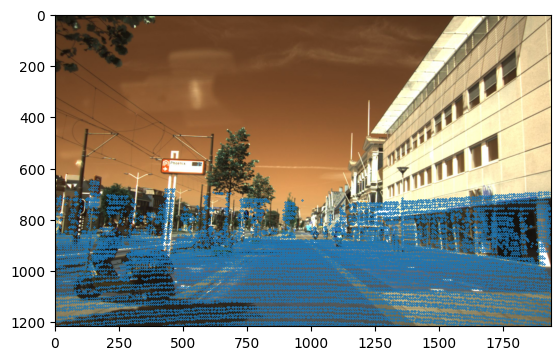

In [21]:
plt.imshow(img)
plt.scatter(pts_img.T[:,0],pts_img.T[:,1],s=0.1)

In [180]:
import os
from multiprocessing import Pool

import mmcv
import numpy as np
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from pyquaternion import Quaternion
import copy

# https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/nuscenes.py#L834
def map_pointcloud_to_image(
    pc,
    im,
    cam_intrinsic,
    min_dist: float = 0.0,
):
    points = np.asarray(pc[:,:3])
    points = points[points[:,0]>min_dist]
    ones = np.ones((points.shape[0], 1))
    homo_points = np.hstack((points, ones)).T
    # Append ones to convert to homogeneous coordinates for transformation
    # Transformation matrix (assuming it's fixed as in your initial code)
    transform_matrix = np.array([
        [6.29238090e+02, -5.27036820e+02, -4.59938064e+00, 1.41321630e+03],
        [3.72013478e+02,  9.42970300e+00, -5.59685543e+02, 1.07637845e+03],
        [9.99925370e-01,  1.22165356e-02,  1.06612091e-04, 1.84000000e+00]
    ])

    # Apply transformation

    uvs = (transform_matrix @ homo_points).T

    # Convert to non-homogeneous coordinates
    uv = uvs[:, :2] / uvs[:, 2, np.newaxis]
    depths = uvs[:, 2]

    # Initialize mask based on depth values being greater than min_dist
    mask = depths > min_dist

    # Update mask based on uv coordinates being within the image boundaries
    mask = np.logical_and(mask, uv[:, 0] > 1)
    mask = np.logical_and(mask, uv[:, 0] < im.shape[1] - 1)  # Image width boundary
    mask = np.logical_and(mask, uv[:, 1] > 1)
    mask = np.logical_and(mask, uv[:, 1] < im.shape[0] - 1)  # Image height boundary

    # Use the mask to filter points and depths
    points_valid = uv[mask]
    depths_valid = depths[mask]

    return points_valid, depths_valid

info_path_train = '/home/xiangyu/SurroundOcc/kradar_dict_train.pkl'
info_path_val = '/home/xiangyu/SurroundOcc/kradar_dict_val.pkl'
lidar_key = 'LIDAR_TOP'
cam_keys = [
'CAM_FRONT'
]

import matplotlib.pyplot as plt

def worker(info):
    lidar_path = info['lidar_path']
    points = np.fromfile(lidar_path,
                         dtype=np.float32,
                         count=-1).reshape(-1, 5)[..., :4]
    
    for i, cam_key in enumerate(cam_keys):
        cam_intrinsic = info['cams'][cam_key]['cam_intrinsic']
        img = mmcv.imread(
            os.path.join(info['cams'][cam_key]['data_path']))
        img = img[:,:1280,:]
        pts_img, depth = map_pointcloud_to_image(
            points.copy(), img, 
            copy.deepcopy(cam_intrinsic))
        print(depth)
        np.concatenate([pts_img, depth[:, None]],
                       axis=1).astype(np.float32).flatten()

        plt.imshow(img)
        plt.scatter(pts_img[:,0],pts_img[:,1],s=0.1)     
        file_name = os.path.split(info['cams'][cam_key]['data_path'])[-1]


[28.07493943 28.12289996 27.40520971 ...  5.58166393  5.54992855
  5.52926123]


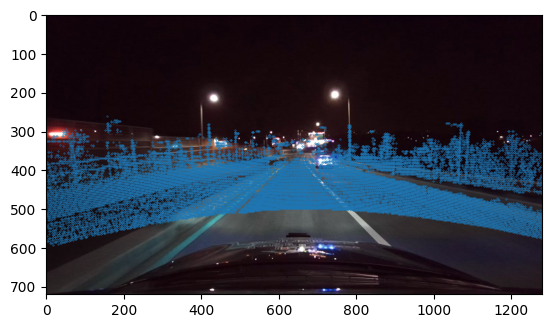

In [181]:
infos = mmcv.load(info_path_train)['infos']
info = infos[1]
worker(info)

In [160]:
pcd = o3d.io.read_point_cloud('/mnt/Kradar/K-Radar/1/os2-64/os2-64_00003.pcd')

In [101]:
points = np.asarray(pcd.points)
print(points.shape)

(131072, 3)


In [113]:
points = np.fromfile('/mnt/data/DataSet/K-RadarOOC/train/1/os2-64/os2-64_00005.pcd.bin',
                         dtype=np.float32,
                         count=-1).reshape(-1, 5)[..., :4]
points.shape

(131072, 4)

In [110]:
from pypcd import pypcd
pcd_data = pypcd.PointCloud.from_path('/mnt/Kradar/K-Radar/1/os2-64/os2-64_00003.pcd')
pcd_data.pc_data['x'].shape

(131072,)

In [111]:
points = np.fromfile(lidar_path,
                         dtype=np.float32,
                         count=-1).reshape(-1, 5)[..., :4]

NameError: name 'lidar_path' is not defined

In [103]:
points.shape

(655360,)

In [ ]:
/mnt/data/DataSet/K-RadarOOC/train/1/os2-64/os2-64_00003.pcd